In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import illoominate
import os

In [2]:
# Define model and parameters
model = "vmis"
metric = "mrr@20"
params = {"m": 200, "k": 200}

location='../data/11306_private'


train_df = pd.read_csv(f"{location}/train.csv", sep='\t').rename(
    columns={'SessionId':'session_id','ItemId':'item_id','Time':'timestamp'}
)
val_df = pd.read_csv(f"{location}/valid.csv", sep='\t').rename(
    columns={'SessionId':'session_id','ItemId':'item_id','Time':'timestamp'}
)
test_df = pd.read_csv(f"{location}/test.csv", sep='\t').rename(
    columns={'SessionId':'session_id','ItemId':'item_id','Time':'timestamp'}
)

#shapley_df = pd.read_csv(f"{location}/__removal_impact_shapley_importance_mrr@21_eval_mrr@21.csv", names=['seed', 'session_id', 'shapley'])
#shapley_df = shapley_df.groupby('session_id')['shapley'].mean().reset_index()


In [3]:
# Step 1: Create (item_id, timestamp) pairs
train_pairs = set(zip(train_df["item_id"], train_df["timestamp"]))
val_pairs = set(zip(val_df["item_id"], val_df["timestamp"]))

# Step 2: Intersect to find duplicates
duplicate_pairs = train_pairs.intersection(val_pairs)
print(f"Found {len(duplicate_pairs)} overlapping (item_id, timestamp) pairs between train and val")

Found 0 overlapping (item_id, timestamp) pairs between train and val


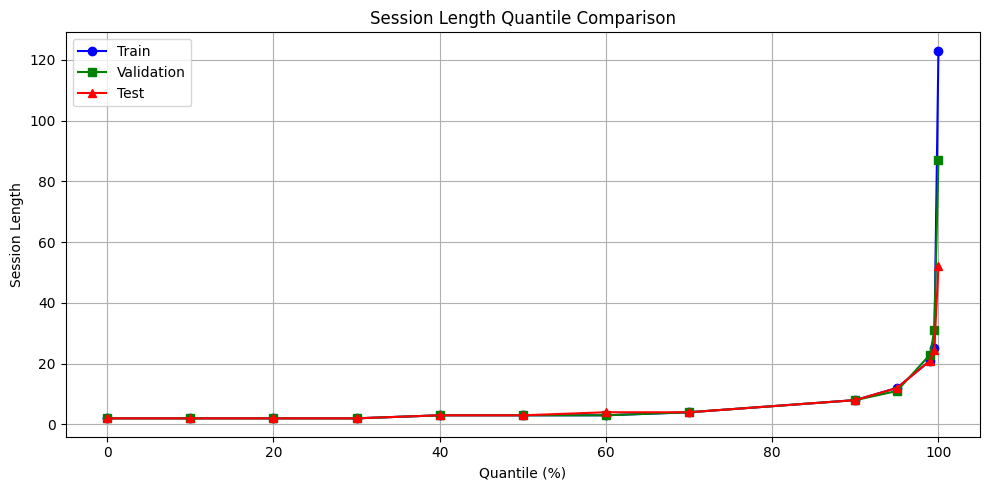

In [4]:
# Compute session lengths
train_session_length = train_df.groupby("session_id")["item_id"].count()
val_session_length = val_df.groupby("session_id")["item_id"].count()
test_session_length = test_df.groupby("session_id")["item_id"].count()


quantiles = [0, 10, 20, 30, 40, 50, 60, 70, 90, 95, 99, 99.5, 100]

# Compute quantiles for each dataset
train_quantiles = np.percentile(train_session_length, quantiles)
val_quantiles = np.percentile(val_session_length, quantiles)
test_quantiles = np.percentile(test_session_length, quantiles)

quantile_df = pd.DataFrame({
    "Quantile (%)": quantiles,
    "Train": train_quantiles,
    "Validation": val_quantiles,
    "Test": test_quantiles
})

# Plot quantile distributions
plt.figure(figsize=(10, 5))
plt.plot(quantiles, train_quantiles, marker='o', linestyle='-', label="Train", color='blue')
plt.plot(quantiles, val_quantiles, marker='s', linestyle='-', label="Validation", color='green')
plt.plot(quantiles, test_quantiles, marker='^', linestyle='-', label="Test", color='red')

plt.xlabel("Quantile (%)")
plt.ylabel("Session Length")
plt.title("Session Length Quantile Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('session_length_comparison.pdf', dpi=300)
plt.show()


In [5]:
illoominate.train_and_evaluate_for_sbr(train_df, test_df, model, metric, params)

session_train.len(): 29324


,metric,score
0,Mrr@20,0.319641


In [6]:
# Compute session lengths
train_session_length = train_df.groupby("session_id")["item_id"].count()

# Define length thresholds (percentiles)
percentiles = quantiles
length_thresholds = {p: np.percentile(train_session_length, p) for p in percentiles}

def do_eval(input_df):
    scores = illoominate.train_and_evaluate_for_sbr(input_df, test_df, model, metric, params)
    result = scores['score'][0]
    return result

# Experiment results storage
results = []

for p, threshold in length_thresholds.items():
    filtered_train = train_df[train_df["session_id"].isin(train_session_length[train_session_length <= threshold].index)]
    result = do_eval(filtered_train)
    results.append({"experiment": f"lengthy_sessions_{p}p", "threshold": threshold, "MRR@20": result})
    print(f"Removed sessions >{threshold} items (p{p}), MRR@20: {result}")


session_train.len(): 11270
Removed sessions >2.0 items (p0), MRR@20: 0.29423690615367615
session_train.len(): 11270
Removed sessions >2.0 items (p10), MRR@20: 0.2942454009585698
session_train.len(): 11270
Removed sessions >2.0 items (p20), MRR@20: 0.2943574815834451
session_train.len(): 11270
Removed sessions >2.0 items (p30), MRR@20: 0.2940723868947249
session_train.len(): 17643
Removed sessions >3.0 items (p40), MRR@20: 0.30573686580888276
session_train.len(): 17643
Removed sessions >3.0 items (p50), MRR@20: 0.3053128407665411
session_train.len(): 17643
Removed sessions >3.0 items (p60), MRR@20: 0.30564972610461155
session_train.len(): 21149
Removed sessions >4.0 items (p70), MRR@20: 0.3118542892090794
session_train.len(): 26631
Removed sessions >8.0 items (p90), MRR@20: 0.32086515305212004
session_train.len(): 28099
Removed sessions >12.0 items (p95), MRR@20: 0.32016970113049703
session_train.len(): 29050
Removed sessions >21.0 items (p99), MRR@20: 0.3198924641739715
session_train.l

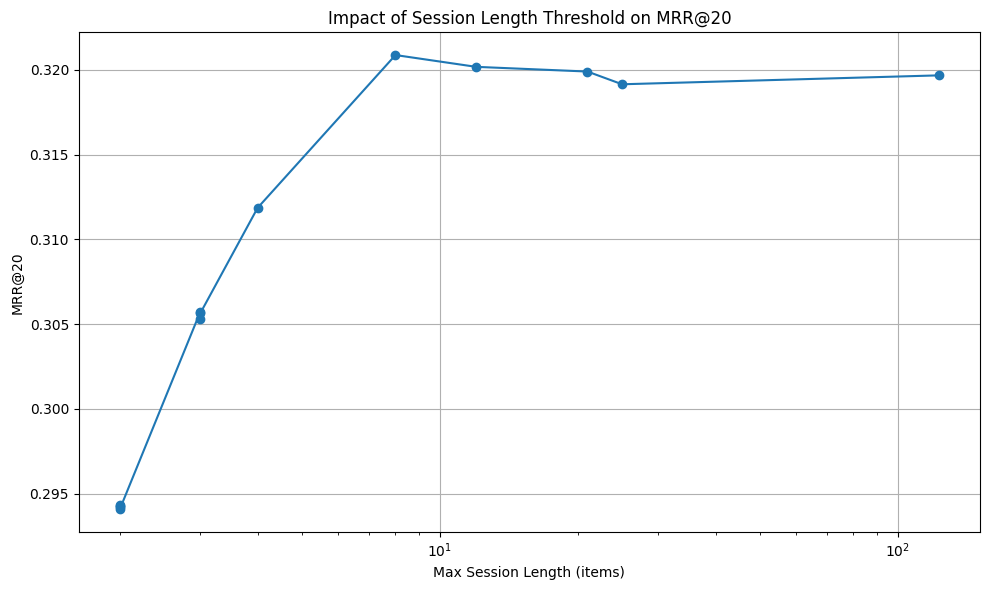

In [7]:
# Extract values for plotting
thresholds = [r["threshold"] for r in results]
mrr_scores = [r["MRR@20"] for r in results]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mrr_scores, marker='o')
plt.title("Impact of Session Length Threshold on MRR@20")
plt.xlabel("Max Session Length (items)")
plt.ylabel("MRR@20")
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.savefig('session_length_vs_mrr.pdf', dpi=300)
plt.show()

In [8]:
shapley_filename = "shapley_values.csv"
if os.path.exists(shapley_filename):
    shapley_values = pd.read_csv(shapley_filename, index_col=0)
else:
    shapley_values = illoominate.data_shapley_values(
        train_df=train_df,
        validation_df=val_df,
        model='vmis',  # Model to be used (e.g., 'vmis' for VMIS-kNN)
        metric='mrr@20',  # Evaluation metric (e.g., Mean Reciprocal Rank at 20)
        params={'m':200, 'k':200, 'seed': 42},  # Model-specific parameters
    )
    shapley_values.to_csv('shapley_values.csv')

In [9]:
shapley_values

,score,session_id
0,2.050399e-05,9703
1,-4.857072e-06,23476
2,0.000000e+00,2495
3,4.564323e-05,20609
4,0.000000e+00,5523
...,...,...
29319,-2.192374e-06,3793
29320,1.407111e-04,2608
29321,-3.239391e-07,12430
29322,1.010971e-05,19117


In [10]:
# Prepare sorted sessions (worst first)

shapley_df = shapley_values

session_lengths = train_df.groupby("session_id")["item_id"].count()
sorted_by_length = session_lengths.sort_values(ascending=False)  # longest first
sorted_by_shapley = shapley_df.set_index("session_id").loc[session_lengths.index].sort_values("score")  # lowest shapley first

# Shared percentiles for removal
percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 90, 95, 99, 99.5]
num_sessions = len(session_lengths)
removal_counts = {p: int(num_sessions * (p / 100)) for p in percentiles}

length_results = []
shapley_results = []

total_interactions = len(train_df)

for p in percentiles:
    num_remove = removal_counts[p]

    # --- Length-based: Remove worst (longest) sessions ---
    sessions_to_remove_length = sorted_by_length.iloc[:num_remove].index
    filtered_train_length = train_df[~train_df["session_id"].isin(sessions_to_remove_length)]
    removed_interactions_length = total_interactions - len(filtered_train_length)

    # --- Shapley-based: Remove worst (lowest shapley) sessions ---
    sessions_to_remove_shapley = sorted_by_shapley.iloc[:num_remove].index
    filtered_train_shapley = train_df[~train_df["session_id"].isin(sessions_to_remove_shapley)]
    removed_interactions_shapley = total_interactions - len(filtered_train_shapley)

    if filtered_train_length.empty or filtered_train_shapley.empty:
        print(f"Skipped p={p}% due to empty train set.")
        continue

    try:
        mrr_length = do_eval(filtered_train_length)
        mrr_shapley = do_eval(filtered_train_shapley)

        length_results.append({
            "percentile_removed": p,
            "removed_sessions": num_remove,
            "removed_interactions": removed_interactions_length,
            "percent_removed": removed_interactions_length / total_interactions,
            "MRR@20": mrr_length
        })

        shapley_results.append({
            "percentile_removed": p,
            "removed_sessions": num_remove,
            "removed_interactions": removed_interactions_shapley,
            "percent_removed": removed_interactions_shapley / total_interactions,
            "MRR@20": mrr_shapley
        })

        print(f"Removed {p}% ({num_remove} sessions): "
              f"Length MRR={mrr_length:.4f} | Shapley MRR={mrr_shapley:.4f}")
    except Exception as e:
        print(f"Error at p={p}%: {e}")

session_train.len(): 29324
session_train.len(): 29324
Removed 0% (0 sessions): Length MRR=0.3198 | Shapley MRR=0.3196
session_train.len(): 26392
session_train.len(): 26392
Removed 10% (2932 sessions): Length MRR=0.3207 | Shapley MRR=0.3307
session_train.len(): 23460
session_train.len(): 23460
Removed 20% (5864 sessions): Length MRR=0.3147 | Shapley MRR=0.3310
session_train.len(): 20527
session_train.len(): 20527
Removed 30% (8797 sessions): Length MRR=0.3119 | Shapley MRR=0.3319
session_train.len(): 17595
session_train.len(): 17595
Removed 40% (11729 sessions): Length MRR=0.3054 | Shapley MRR=0.3316
session_train.len(): 14662
session_train.len(): 14662
Removed 50% (14662 sessions): Length MRR=0.3036 | Shapley MRR=0.3323
session_train.len(): 11730
session_train.len(): 11730
Removed 60% (17594 sessions): Length MRR=0.2958 | Shapley MRR=0.3300
session_train.len(): 8798
session_train.len(): 8798
Removed 70% (20526 sessions): Length MRR=0.2891 | Shapley MRR=0.3287
session_train.len(): 2933


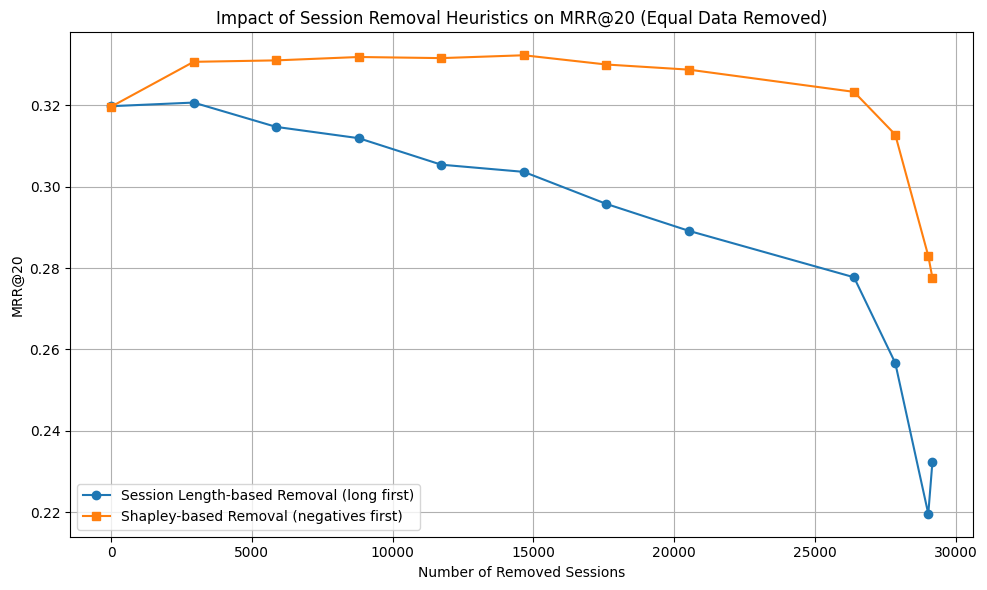

In [11]:
plt.figure(figsize=(10, 6))

# Plot
plt.plot(
    [r["removed_sessions"] for r in length_results],
    [r["MRR@20"] for r in length_results],
    marker='o', label='Session Length-based Removal (long first)'
)

plt.plot(
    [r["removed_sessions"] for r in shapley_results],
    [r["MRR@20"] for r in shapley_results],
    marker='s', label='Shapley-based Removal (negatives first)'
)

plt.title("Impact of Session Removal Heuristics on MRR@20 (Equal Data Removed)")
plt.xlabel("Number of Removed Sessions")
plt.ylabel("MRR@20")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("removal_comparison_equalized.pdf", dpi=300)
plt.show()

In [12]:
# Prepare reversed sorts for best-to-worst removal
sorted_by_length_best = session_lengths.sort_values(ascending=True)  # shortest sessions first = "best" if short = good
sorted_by_shapley_best = shapley_df.set_index("session_id").loc[session_lengths.index].sort_values("score", ascending=False)  # highest shapley first
best_length_results = []
best_shapley_results = []

for p in percentiles:
    num_remove = removal_counts[p]

    # --- Length-based: Remove best (shortest) sessions ---
    sessions_to_remove_length = sorted_by_length_best.iloc[:num_remove].index
    filtered_train_length = train_df[~train_df["session_id"].isin(sessions_to_remove_length)]
    removed_interactions_length = total_interactions - len(filtered_train_length)

    # --- Shapley-based: Remove best (highest shapley) sessions ---
    sessions_to_remove_shapley = sorted_by_shapley_best.iloc[:num_remove].index
    filtered_train_shapley = train_df[~train_df["session_id"].isin(sessions_to_remove_shapley)]
    removed_interactions_shapley = total_interactions - len(filtered_train_shapley)

    if filtered_train_length.empty or filtered_train_shapley.empty:
        print(f"Skipped p={p}% due to empty train set.")
        continue

    try:
        mrr_length = do_eval(filtered_train_length)
        mrr_shapley = do_eval(filtered_train_shapley)

        best_length_results.append({
            "percentile_removed": p,
            "removed_sessions": num_remove,
            "removed_interactions": removed_interactions_length,
            "percent_removed": removed_interactions_length / total_interactions,
            "MRR@20": mrr_length
        })

        best_shapley_results.append({
            "percentile_removed": p,
            "removed_sessions": num_remove,
            "removed_interactions": removed_interactions_shapley,
            "percent_removed": removed_interactions_shapley / total_interactions,
            "MRR@20": mrr_shapley
        })

        print(f"[BEST REMOVAL] Removed top {p}% ({num_remove} sessions): "
              f"Length MRR={mrr_length:.4f} | Shapley MRR={mrr_shapley:.4f}")
    except Exception as e:
        print(f"Error at p={p}%: {e}")

session_train.len(): 29324
session_train.len(): 29324
[BEST REMOVAL] Removed top 0% (0 sessions): Length MRR=0.3197 | Shapley MRR=0.3197
session_train.len(): 26392
session_train.len(): 26392
[BEST REMOVAL] Removed top 10% (2932 sessions): Length MRR=0.3184 | Shapley MRR=0.2959
session_train.len(): 23460
session_train.len(): 23460
[BEST REMOVAL] Removed top 20% (5864 sessions): Length MRR=0.3184 | Shapley MRR=0.2828
session_train.len(): 20527
session_train.len(): 20527
[BEST REMOVAL] Removed top 30% (8797 sessions): Length MRR=0.3176 | Shapley MRR=0.2732
session_train.len(): 17595
session_train.len(): 17595
[BEST REMOVAL] Removed top 40% (11729 sessions): Length MRR=0.3177 | Shapley MRR=0.2670
session_train.len(): 14662
session_train.len(): 14662
[BEST REMOVAL] Removed top 50% (14662 sessions): Length MRR=0.3159 | Shapley MRR=0.2663
session_train.len(): 11730
session_train.len(): 11730
[BEST REMOVAL] Removed top 60% (17594 sessions): Length MRR=0.3126 | Shapley MRR=0.2637
session_train.

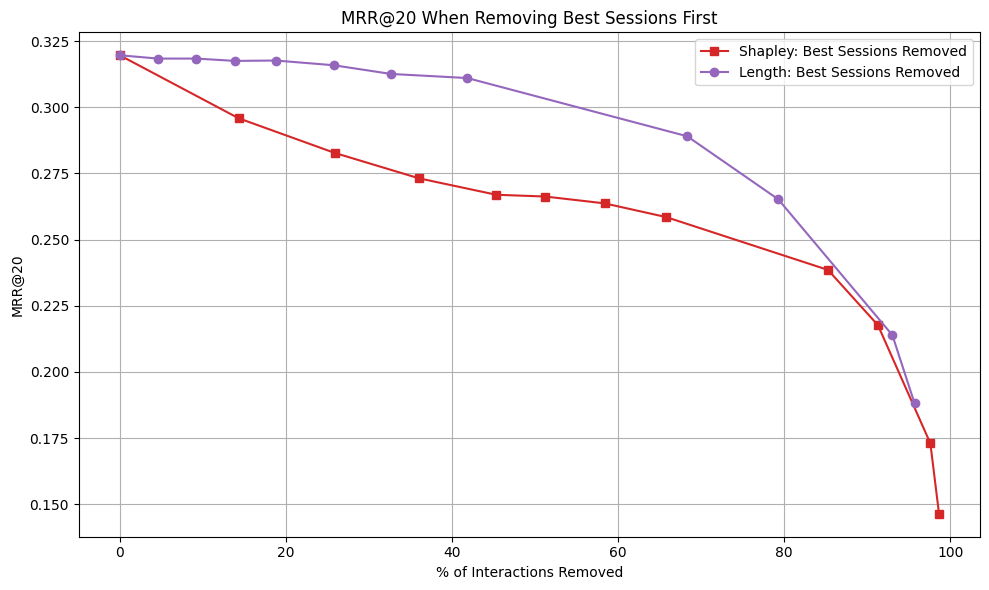

In [13]:
plt.figure(figsize=(10, 6))

# Shapley-based (best sessions removed)
plt.plot(
    [r["percent_removed"] * 100 for r in best_shapley_results],
    [r["MRR@20"] for r in best_shapley_results],
    marker='s', label='Shapley: Best Sessions Removed', color='tab:red'
)

# Length-based (best sessions removed)
plt.plot(
    [r["percent_removed"] * 100 for r in best_length_results],
    [r["MRR@20"] for r in best_length_results],
    marker='o', label='Length: Best Sessions Removed', color='tab:purple'
)

plt.title("MRR@20 When Removing Best Sessions First")
plt.xlabel("% of Interactions Removed")
plt.ylabel("MRR@20")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("mrr_remove_best_sessions.pdf", dpi=300)
plt.show()

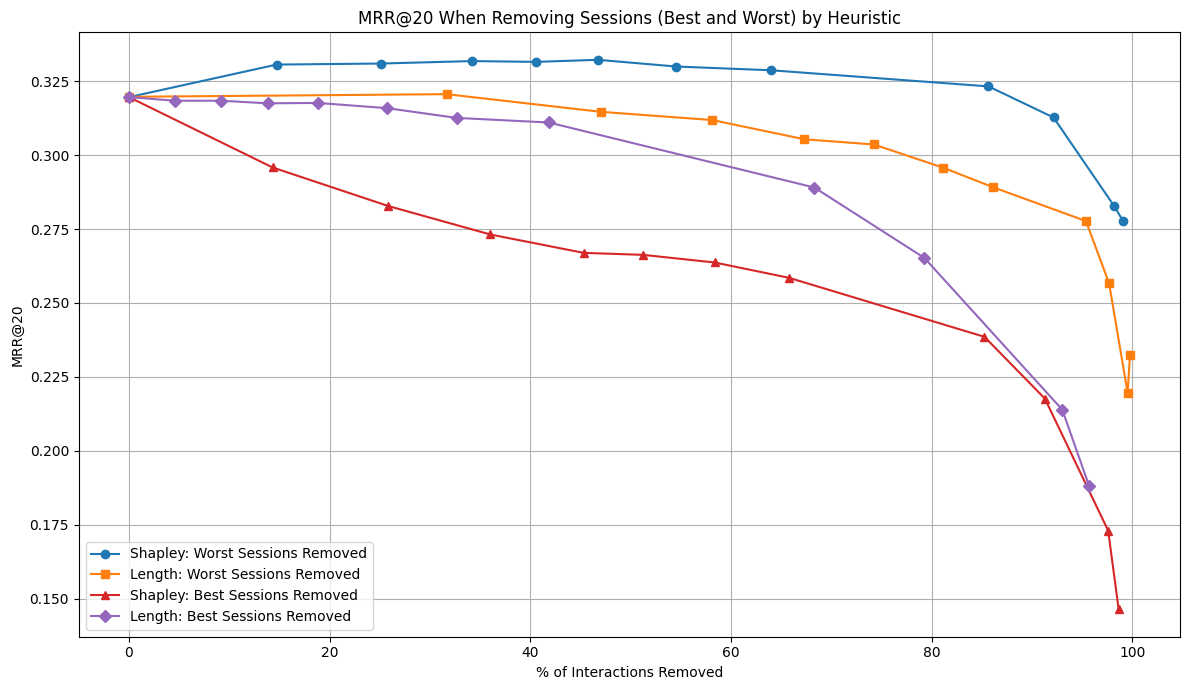

In [14]:
plt.figure(figsize=(12, 7))

# Worst → Best removal: Shapley
plt.plot(
    [r["percent_removed"] * 100 for r in shapley_results],
    [r["MRR@20"] for r in shapley_results],
    marker='o', color='tab:blue', label='Shapley: Worst Sessions Removed'
)

# Worst → Best removal: Length
plt.plot(
    [r["percent_removed"] * 100 for r in length_results],
    [r["MRR@20"] for r in length_results],
    marker='s', color='tab:orange', label='Length: Worst Sessions Removed'
)

# Best → Worst removal: Shapley
plt.plot(
    [r["percent_removed"] * 100 for r in best_shapley_results],
    [r["MRR@20"] for r in best_shapley_results],
    marker='^', color='tab:red', label='Shapley: Best Sessions Removed'
)

# Best → Worst removal: Length
plt.plot(
    [r["percent_removed"] * 100 for r in best_length_results],
    [r["MRR@20"] for r in best_length_results],
    marker='D', color='tab:purple', label='Length: Best Sessions Removed'
)

# Axes, title, legend
plt.title("MRR@20 When Removing Sessions (Best and Worst) by Heuristic")
plt.xlabel("% of Interactions Removed")
plt.ylabel("MRR@20")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("summary_mrr_removal_all_heuristics.pdf", dpi=300)
plt.show()

In [15]:
import numpy as np

# Filter to sessions present in training data
shapley_df = shapley_df[shapley_df["session_id"].isin(train_df["session_id"].unique())]

# Count how many sessions have negative Shapley values
negative_shapley_df = shapley_df[shapley_df["score"] < 0]
max_remove = len(negative_shapley_df)
print(f"Sessions with negative Shapley value: {max_remove}")

# === Prepare sorted sessions for removal ===
session_lengths = train_df.groupby("session_id")["item_id"].count()
sorted_by_shapley = shapley_df.set_index("session_id").loc[session_lengths.index].sort_values("score")
sorted_by_length = session_lengths.sort_values(ascending=False)

# === Loop settings ===
step_sizes = np.linspace(0, max_remove, num=100, dtype=int)
total_interactions = len(train_df)

shapley_results = []
length_results = []

for count in step_sizes:
    # Sessions to remove
    remove_sids_shapley = sorted_by_shapley.iloc[:count].index
    remove_sids_length = sorted_by_length.iloc[:count].index

    # Filter training data
    filtered_train_shapley = train_df[~train_df["session_id"].isin(remove_sids_shapley)]
    filtered_train_length = train_df[~train_df["session_id"].isin(remove_sids_length)]

    # % of interactions removed
    percent_removed_shapley = 1 - (len(filtered_train_shapley) / total_interactions)
    percent_removed_length = 1 - (len(filtered_train_length) / total_interactions)

    # Evaluate
    try:
        score_shapley = illoominate.train_and_evaluate_for_sbr(filtered_train_shapley, test_df, model, metric, params)['score'][0]
        score_length = illoominate.train_and_evaluate_for_sbr(filtered_train_length, test_df, model, metric, params)['score'][0]

        shapley_results.append({
            "sessions_removed": count,
            "percent_removed": percent_removed_shapley,
            "MRR@20": score_shapley
        })

        length_results.append({
            "sessions_removed": count,
            "percent_removed": percent_removed_length,
            "MRR@20": score_length
        })

        print(f"{count} sessions removed | MRR@20 (Shapley): {score_shapley:.4f} | MRR@20 (Length): {score_length:.4f}")
    
    except Exception as e:
        print(f"Error at step {count}: {e}")

Sessions with negative Shapley value: 10055
session_train.len(): 29324
session_train.len(): 29324
0 sessions removed | MRR@20 (Shapley): 0.3196 | MRR@20 (Length): 0.3197
session_train.len(): 29223
session_train.len(): 29223
101 sessions removed | MRR@20 (Shapley): 0.3220 | MRR@20 (Length): 0.3189
session_train.len(): 29121
session_train.len(): 29121
203 sessions removed | MRR@20 (Shapley): 0.3231 | MRR@20 (Length): 0.3195
session_train.len(): 29020
session_train.len(): 29020
304 sessions removed | MRR@20 (Shapley): 0.3231 | MRR@20 (Length): 0.3196
session_train.len(): 28918
session_train.len(): 28918
406 sessions removed | MRR@20 (Shapley): 0.3235 | MRR@20 (Length): 0.3198
session_train.len(): 28817
session_train.len(): 28817
507 sessions removed | MRR@20 (Shapley): 0.3239 | MRR@20 (Length): 0.3196
session_train.len(): 28715
session_train.len(): 28715
609 sessions removed | MRR@20 (Shapley): 0.3241 | MRR@20 (Length): 0.3196
session_train.len(): 28614
session_train.len(): 28614
710 sess

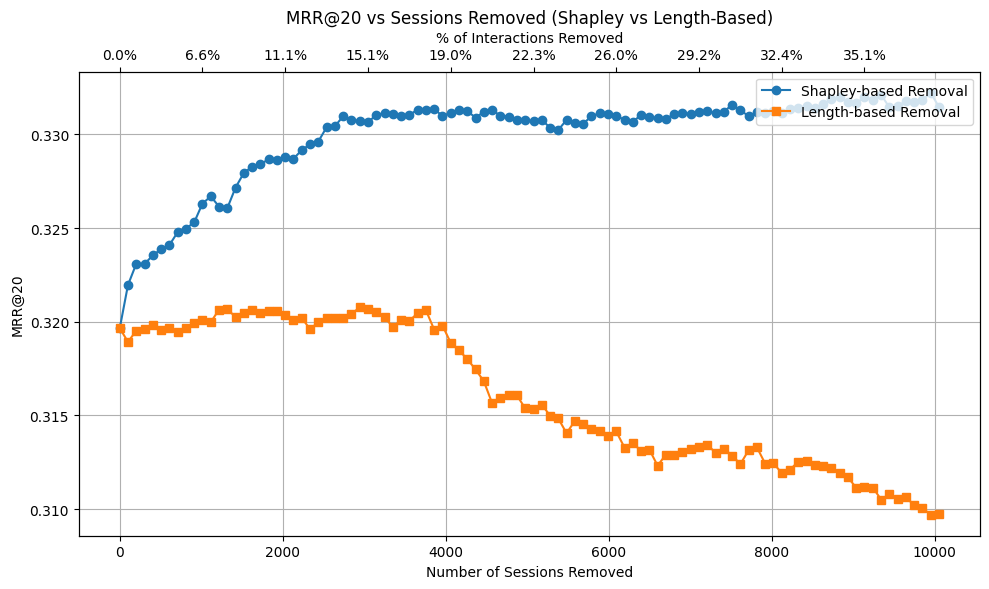

In [16]:
# Extract plotting data
x_shapley = [r["sessions_removed"] for r in shapley_results]
x_length = [r["sessions_removed"] for r in length_results]
y_shapley = [r["MRR@20"] for r in shapley_results]
y_length = [r["MRR@20"] for r in length_results]
x_percent = [r["percent_removed"] * 100 for r in shapley_results]  # assuming aligned steps

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MRR@20
ax1.plot(x_shapley, y_shapley, marker='o', label='Shapley-based Removal', color='tab:blue')
ax1.plot(x_length, y_length, marker='s', label='Length-based Removal', color='tab:orange')

ax1.set_xlabel("Number of Sessions Removed")
ax1.set_ylabel("MRR@20")
ax1.grid(True)
ax1.legend(loc="upper right")

# Secondary x-axis for % of interactions removed
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
tick_locs = x_shapley[::10]
tick_labels = [f"{x_percent[i]:.1f}%" for i in range(0, len(x_percent), 10)]
ax2.set_xticks(tick_locs)
ax2.set_xticklabels(tick_labels)
ax2.set_xlabel("% of Interactions Removed")

plt.title("MRR@20 vs Sessions Removed (Shapley vs Length-Based)")
plt.tight_layout()
plt.savefig("mrr_vs_session_removal_dual_axis.pdf", dpi=300)
plt.show()

In [17]:
print(shapley_results[0])  # should include: sessions_removed, percent_removed, MRR@20

{'sessions_removed': np.int64(0), 'percent_removed': 0.0, 'MRR@20': np.float64(0.3196496822501806)}


In [18]:
# Convert results to DataFrames
shapley_df = pd.DataFrame(shapley_results)
shapley_df["method"] = "Shapley"

length_df = pd.DataFrame(length_results)
length_df["method"] = "Length"

# Combine both into a single DataFrame
plot_data_df = pd.concat([shapley_df, length_df], ignore_index=True)

# Save to CSV
plot_data_df.to_csv("mrr_removal_curve_data.csv", index=False)

print("Saved MRR curve data to 'mrr_removal_curve_data.csv'")

Saved MRR curve data to 'mrr_removal_curve_data.csv'
